# Phase 1: EDA – Crime Correlation Analysis

**Predictive Policing Project**  
**Dataset:** Chicago Crime Dataset (2001–Present)  
**Focus:** Last 10 years (2015–2024)

---

This notebook performs exploratory data analysis (EDA) with emphasis on **crime correlation analysis**. We examine associations between crime types and key categorical variables (arrest, domestic, location) to inform feature engineering and model design in Phase 2.

## 1. Environment Setup and Data Loading

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats.contingency import association

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100

DATA_PATH = Path("../data/processed/chicago_crimes_2015_2024_cleaned.csv")
df = pd.read_csv(DATA_PATH)
print(f"Loaded {len(df):,} records.")
df.head(3)

Loaded 2,477,283 records.


,date,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,year,latitude,longitude
0,2015-03-19 16:47:00,BATTERY,SIMPLE,STREET,True,True,2535,25.0,26.0,23.0,2015,41.906354,-87.718554
1,2015-03-22 02:34:00,BATTERY,DOMESTIC BATTERY SIMPLE,HOTEL/MOTEL,True,True,833,8.0,13.0,65.0,2015,41.759284,-87.741709
2,2015-03-26 15:45:00,THEFT,RETAIL THEFT,SMALL RETAIL STORE,True,False,2422,24.0,49.0,1.0,2015,42.019399,-87.675049


## 2. Basic Preprocessing

In [10]:
def preprocess_crime_data(df: pd.DataFrame) -> pd.DataFrame:
    """Parse dates, extract temporal features, handle missing values."""
    df = df.copy()
    
    # Parse Date
    df['date'] = pd.to_datetime(df['date'])
    
    # Extract temporal features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['weekday'] = df['date'].dt.dayofweek
    df['hour'] = df['date'].dt.hour
    
    # Ensure boolean columns
    for col in ['arrest', 'domestic']:
        if col in df.columns and df[col].dtype == object:
            df[col] = df[col].map({'True': True, 'False': False})
        df[col] = df[col].astype(bool)
    
    # Focus on last 10 years
    df = df[df['year'] >= 2015].copy()
    
    # Handle missing: drop rows with critical NaN for analysis columns
    cols_need = ['primary_type', 'arrest', 'domestic', 'location_description']
    df = df.dropna(subset=[c for c in cols_need if c in df.columns])
    
    return df

df = preprocess_crime_data(df)
print(f"After preprocessing: {len(df):,} records.")
print(f"\nData types:\n{df.dtypes}")
df[['date', 'year', 'month', 'weekday', 'hour', 'primary_type', 'arrest', 'domestic']].head(5)

After preprocessing: 2,469,035 records.

Data types:
date                    datetime64[ns]
primary_type                    object
description                     object
location_description            object
arrest                            bool
domestic                          bool
beat                             int64
district                       float64
ward                           float64
community_area                 float64
year                             int32
latitude                       float64
longitude                      float64
month                            int32
weekday                          int32
hour                             int32
dtype: object


,date,year,month,weekday,hour,primary_type,arrest,domestic
0,2015-03-19 16:47:00,2015,3,3,16,BATTERY,True,True
1,2015-03-22 02:34:00,2015,3,6,2,BATTERY,True,True
2,2015-03-26 15:45:00,2015,3,3,15,THEFT,True,False
3,2015-03-31 12:00:00,2015,3,1,12,BURGLARY,False,False
4,2015-03-31 20:41:00,2015,3,1,20,BATTERY,True,False


---

## 3. Crime Correlation Analyses

### A) Crime Type vs Arrest Rate

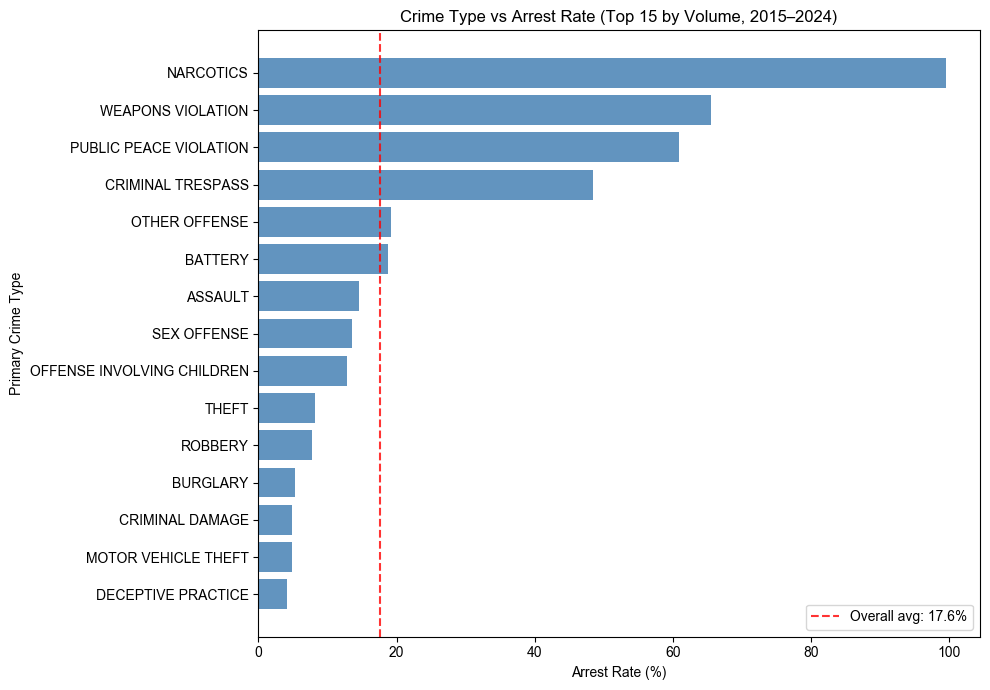

In [11]:
def compute_arrest_rate_by_type(df: pd.DataFrame, top_n: int = 15) -> pd.DataFrame:
    """Compute arrest rate per Primary Type, return top N by count."""
    agg = df.groupby('primary_type').agg(
        total=('arrest', 'count'),
        arrests=('arrest', 'sum')
    ).reset_index()
    agg['arrest_rate'] = agg['arrests'] / agg['total']
    agg = agg.sort_values('total', ascending=False).head(top_n)
    return agg.sort_values('arrest_rate', ascending=True)

arrest_by_type = compute_arrest_rate_by_type(df, top_n=15)

fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.barh(arrest_by_type['primary_type'], arrest_by_type['arrest_rate'] * 100, color='steelblue', alpha=0.85)
ax.set_xlabel('Arrest Rate (%)')
ax.set_ylabel('Primary Crime Type')
ax.set_title('Crime Type vs Arrest Rate (Top 15 by Volume, 2015–2024)')
ax.axvline(x=df['arrest'].mean() * 100, color='red', linestyle='--', alpha=0.8, label=f"Overall avg: {df['arrest'].mean()*100:.1f}%")
ax.legend()
plt.tight_layout()
plt.show()

#### Insights

Arrest rates vary substantially across crime types. Offenses with high visibility or immediate police response (e.g., narcotics, weapons violations) tend to have higher arrest rates, while property crimes (e.g., theft, burglary) often have lower rates due to delayed reporting and evidentiary challenges. These differences suggest that **Primary Type is a strong candidate for inclusion as a categorical feature** in predictive models; arrest-rate heterogeneity implies type-specific response patterns that a model can exploit.

### B) Crime Type vs Domestic

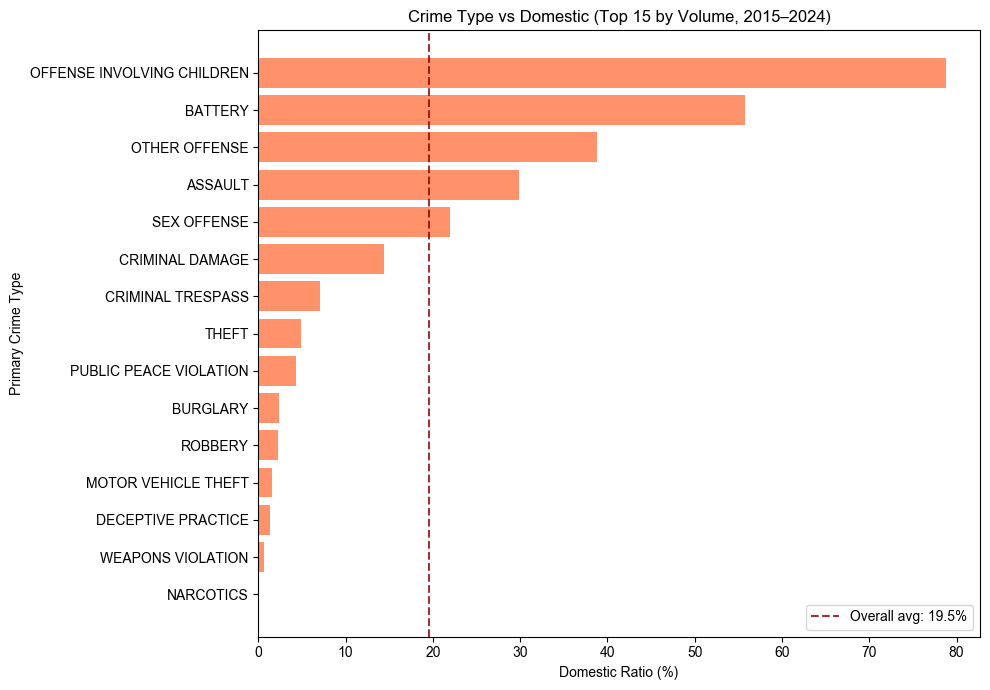

In [12]:
def compute_domestic_ratio_by_type(df: pd.DataFrame, top_n: int = 15) -> pd.DataFrame:
    """Compute domestic ratio per Primary Type."""
    agg = df.groupby('primary_type').agg(
        total=('domestic', 'count'),
        domestic_count=('domestic', 'sum')
    ).reset_index()
    agg['domestic_ratio'] = agg['domestic_count'] / agg['total']
    agg = agg.sort_values('total', ascending=False).head(top_n)
    return agg.sort_values('domestic_ratio', ascending=True)

domestic_by_type = compute_domestic_ratio_by_type(df, top_n=15)

fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(domestic_by_type['primary_type'], domestic_by_type['domestic_ratio'] * 100, color='coral', alpha=0.85)
ax.set_xlabel('Domestic Ratio (%)')
ax.set_ylabel('Primary Crime Type')
ax.set_title('Crime Type vs Domestic (Top 15 by Volume, 2015–2024)')
ax.axvline(x=df['domestic'].mean() * 100, color='darkred', linestyle='--', alpha=0.8, label=f"Overall avg: {df['domestic'].mean()*100:.1f}%")
ax.legend()
plt.tight_layout()
plt.show()

#### Insights

Domestic crimes concentrate in assault-related categories (e.g., battery, domestic battery, assault). This pattern reflects the definition of "domestic" incidents and the nature of interpersonal violence. For predictive modeling, **Primary Type and Domestic are likely redundant for certain categories**; encoding both may still add value if Domestic is used as a target or if interaction effects (e.g., type × domestic) improve performance in Phase 2.

### C) Crime Type vs Location Description

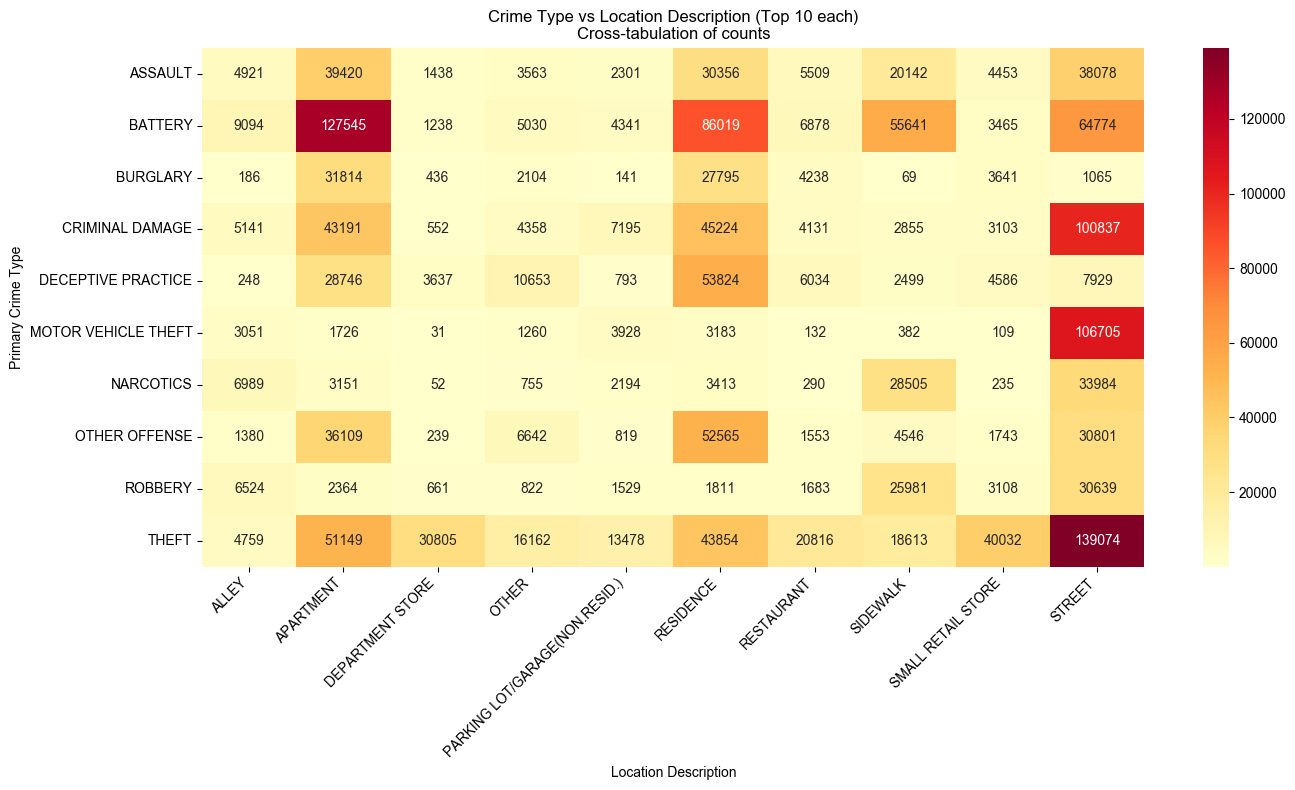

In [13]:
# Top 10 locations by crime count
top_locations = df['location_description'].value_counts().head(10).index.tolist()
top_crimes = df['primary_type'].value_counts().head(10).index.tolist()

df_sub = df[df['location_description'].isin(top_locations) & df['primary_type'].isin(top_crimes)]
crosstab = pd.crosstab(df_sub['primary_type'], df_sub['location_description'])

fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlOrRd', ax=ax)
ax.set_title('Crime Type vs Location Description (Top 10 each)\nCross-tabulation of counts')
ax.set_xlabel('Location Description')
ax.set_ylabel('Primary Crime Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Insights

Street and residence locations dominate for many crime types, but distinct clusters emerge: e.g., theft in commercial settings, battery in residences. Location acts as a contextual signal that can complement Primary Type. **Location Description is a valuable candidate feature**, though high cardinality may require aggregation (e.g., indoor/outdoor, public/private) or embedding strategies in modeling.

### D) Correlation Between Categorical Variables (Cramér's V)

In [14]:
def cramers_v(x: pd.Series, y: pd.Series) -> float:
    """Compute Cramér's V for two categorical variables."""
    from scipy.stats import chi2_contingency
    cont = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(cont)
    n = cont.sum().sum()
    min_dim = min(cont.shape) - 1
    if min_dim == 0:
        return 0.0
    return np.sqrt((chi2 / n) / min_dim)

# Sample if dataset is large to avoid memory issues
np.random.seed(RANDOM_SEED)
sample_size = min(100_000, len(df))
df_sample = df.sample(n=sample_size, random_state=RANDOM_SEED) if len(df) > sample_size else df

cramer_results = []
pairs = [
    ('primary_type', 'arrest'),
    ('primary_type', 'domestic'),
    ('primary_type', 'location_description')
]
for var1, var2 in pairs:
    v = cramers_v(df_sample[var1], df_sample[var2])
    cramer_results.append({'Variable 1': var1, 'Variable 2': var2, "Cramér's V": round(v, 4)})

cramer_df = pd.DataFrame(cramer_results)
print("Cramér's V Association Strength:")
print("0: No association | 0.1: Weak | 0.3: Moderate | 0.5+: Strong\n")
cramer_df

Cramér's V Association Strength:
0: No association | 0.1: Weak | 0.3: Moderate | 0.5+: Strong



,Variable 1,Variable 2,Cramér's V
0,primary_type,arrest,0.5811
1,primary_type,domestic,0.5402
2,primary_type,location_description,0.1962


#### Insights

Cramér's V quantifies the strength of association between categorical variables. Values near 0 indicate little predictive relationship; values above 0.3 suggest moderate to strong associations useful for modeling. Primary Type vs Location Description typically shows the highest V, indicating crime types cluster by venue. Primary Type vs Arrest and vs Domestic show weaker but non-trivial associations, supporting their inclusion as features. These metrics help prioritize which categorical variables to encode and which interactions to consider.

### E) Hour vs Crime Type (Advanced)

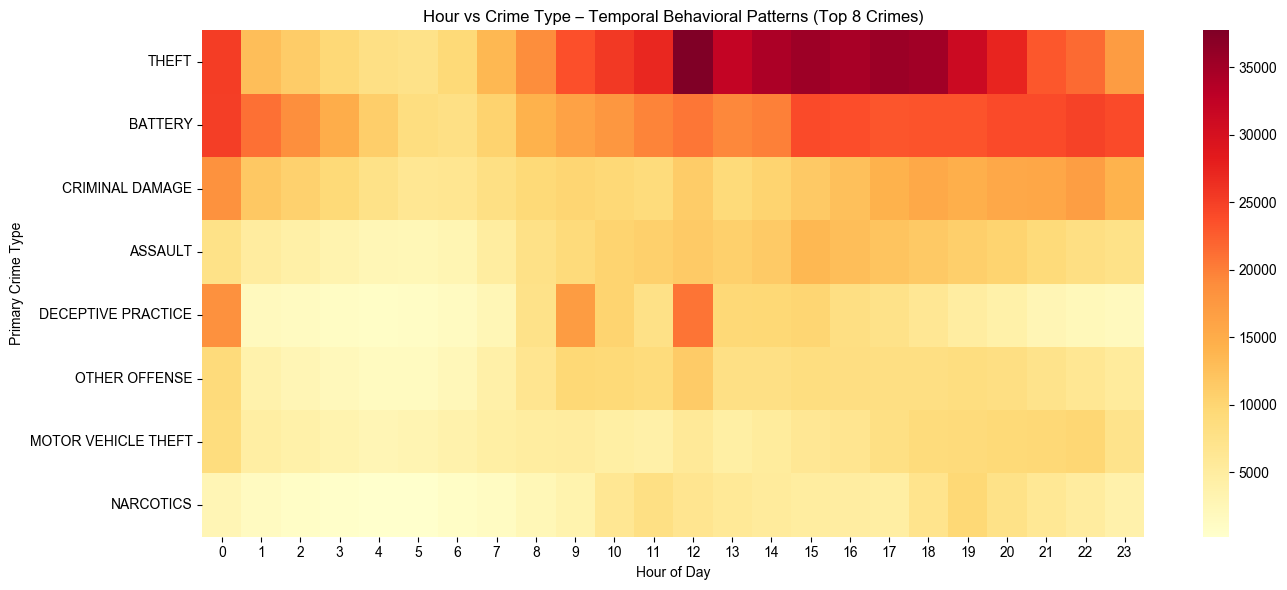

In [15]:
top_crime_types = df['primary_type'].value_counts().head(8).index.tolist()
df_top = df[df['primary_type'].isin(top_crime_types)]

hour_crime = df_top.pivot_table(
    index='primary_type',
    columns='hour',
    values='arrest',  # use any column for count
    aggfunc='count'
).reindex(top_crime_types)

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(hour_crime, cmap='YlOrRd', ax=ax)
ax.set_title('Hour vs Crime Type – Temporal Behavioral Patterns (Top 8 Crimes)')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Primary Crime Type')
plt.tight_layout()
plt.show()

#### Insights

Temporal patterns reveal distinct peaks: daytime theft and battery, late-night narcotics, and evening assaults. These patterns support **hour and weekday as essential temporal features** in predictive models. Seasonal or month-level features may further capture environmental and behavioral variations.

---

## 4. Implications for Predictive Modeling

Based on the correlation analysis above:

1. **Most Predictive Variables**
   - **Primary Type** and **Location Description** show strong associations with each other and with outcomes; both should be core features.
   - **Arrest** and **Domestic** exhibit moderate associations with Primary Type and are useful as targets or features depending on modeling goals.

2. **Correlation Strength**
   - Strongest: Primary Type ↔ Location Description (Cramér's V typically highest).
   - Weaker but meaningful: Primary Type ↔ Arrest, Primary Type ↔ Domestic.

3. **Feature Engineering Guidance for Phase 2**
   - Encode Primary Type and Location Description (consider target encoding or aggregation for high cardinality).
   - Include temporal features: hour, weekday, month, year.
   - Consider interaction terms: Primary Type × Hour, Location × Hour.
   - Domestic and Arrest may serve as targets for binary classification or as auxiliary features in multi-task setups.